In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display, Math

%matplotlib inline

Hamaus+14 universal profile of the void : https://arxiv.org/pdf/1403.5499.pdf

In [2]:
def prof(r, dc, rs, rv, alpha, beta):
    return dc*(1-(r/rs)**alpha)/(1+(r/rv)**beta)

Consider the typical void having void radius rv=4. We will track the profile to ~3rv. Other profile parameters are taken from Hamaus et al. 2014, e.g. Fig. 2

In [3]:
dc = -0.8
rs  = 2.0
rv =  4.0
alpha = 1.5
beta = 7.0
p = np.empty(5)
p[0]=dc
p[1]=rs
p[2]=rv
p[3]=alpha
p[4]=beta

r = np.linspace(0,15,100)

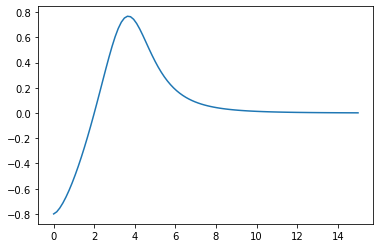

In [4]:
plt.plot(r, prof(r, *p), "C0-")
plt.show()

Prepare the grid point in 3D space. Note that the 8 quadrants are treated as independent region and the grid is prepared only for the first quadrant.

In [53]:
grid = np.linspace(0,r[-1]/np.sqrt(3.),4)
grid += 0.25#(grid[1]-grid[0])/2./2.
print (grid)

[0.25       3.13675135 6.02350269 8.91025404]


In [54]:
mesh = np.array(np.meshgrid(grid,grid,grid, indexing="ij"))
rmesh = np.sqrt(np.sum(mesh**2, axis=0))
mask_mesh = rmesh>0
mask_mesh

array([[[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]],

       [[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]],

       [[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]],

       [[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]]])



Make a stacked void data over Nstack voids. Furthermore, the void profile is stacked within the void to the first quadrant, which makes the profile 8 times Nstack stacking.



In [55]:
delta = None
Nstack = 10
for ip in range(8*Nstack):

    delta_ = np.random.normal(loc=prof(rmesh[mask_mesh], dc, rs, rv, alpha, beta), scale=0.1*np.sqrt(8*Nstack))
    
    if delta is None:
        delta  = delta_.flatten()[np.newaxis,:]
    else:
        delta = np.append(delta, delta_.flatten()[np.newaxis,:],axis=0)

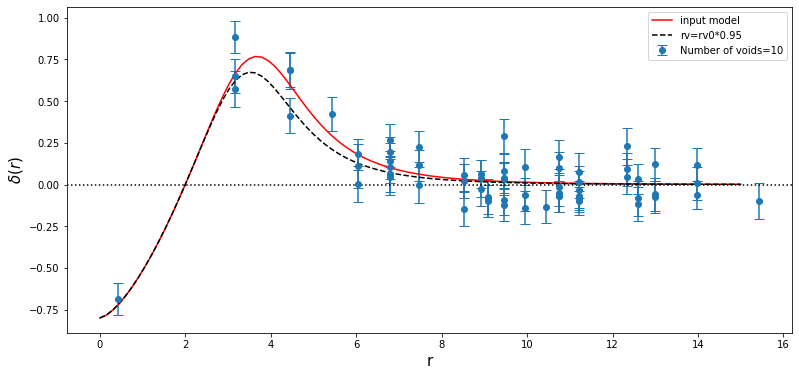

In [56]:
n = delta.shape[0]
plt.figure(figsize=(13,6))
label="Number of voids=%i"%Nstack
plt.errorbar(rmesh[mask_mesh].flatten(), np.mean(delta,axis=0), np.std(delta,axis=0)/np.sqrt(n), ls="none", marker="o", capsize=5, label=label)
plt.plot(r, prof(r, *p), "r-", label="input model")
p1 = p*np.array([1.0, 1.0, 0.95, 1.0, 1.0])
plt.plot(r, prof(r, *p1), "k--", label="rv=rv0*0.95")
plt.axhline(y=0, ls=":", color="k")
plt.xlabel("r", fontsize=15)
plt.ylabel(r"$\delta(r)$", fontsize=15)
plt.legend()
plt.show()

Well, it seems that the r_v=r_v*0.95 model can be well constrained by the 10 stacked voids.  
Note that the errorbars represent the uncertainty of the mean, averaged over Nstack*8 samples.  


Allright, Let's move on to the Likelihood analysis.

In [57]:
cov = np.cov(delta.T)
corr = cov.copy()
for i1 in range(cov.shape[0]):
    for i2 in range(cov.shape[1]):
        corr[i1,i2] = cov[i1,i2]/np.sqrt(cov[i1,i1]*cov[i2,i2])

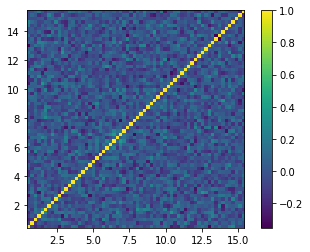

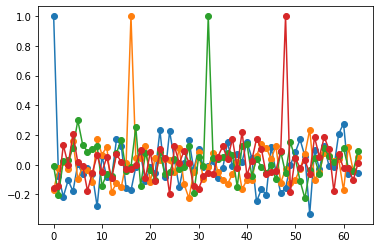

In [58]:
plt.imshow(corr.T, extent=[rmesh.min(), rmesh.max(), rmesh.min(), rmesh.max()], origin="lower")
plt.colorbar()
plt.show()
#
for i in range(0,corr.shape[0], 16):
    plt.plot(corr[i], "C%io-"%(int(i/16)))
plt.show()

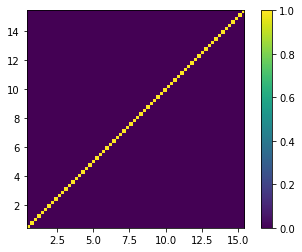

-4.3050652832107156e-14
inversion success


In [59]:
invcov = np.linalg.inv(cov)

# check the matrix inversion
test = np.dot(invcov, cov)
plt.imshow(test.T, extent=[rmesh.min(), rmesh.max(), rmesh.min(), rmesh.max()], origin="lower")
plt.colorbar()
plt.show()
check = np.sum(test-np.identity(test.shape[0]))
print (check)

if ( np.abs(check) < 1e-10 ):
    print ("inversion success")
else:
    print ("covariance may be noisy and try to SVD")
    u, s, v = np.linalg.svd(cov)
    plt.plot(s, "C0o-")
    plt.yscale("log")
    plt.show()
    print (s)
    ss=s.copy()
    th = 1e-3
    ss[s>th] = 1./s[s>th]
    ss[s<=th]=0.
    sig = np.dot(v, np.dot(np.diag(ss), u))
    test2 = np.dot(sig, cov)
    plt.imshow(test2.T, extent=[rmesh.min(), rmesh.max(), rmesh.min(), rmesh.max()], origin="lower")
    plt.colorbar()
    plt.show()

    invcov = sig

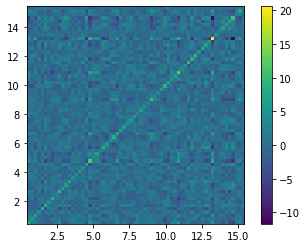

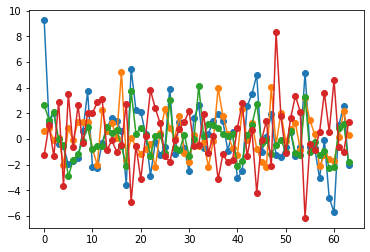

In [60]:
plt.imshow(invcov.T, extent=[rmesh.min(), rmesh.max(), rmesh.min(), rmesh.max()], origin="lower")
plt.colorbar()
plt.show()
#
for i in range(0,corr.shape[0], 16):
    plt.plot(invcov[i], "C%io-"%(int(i/16)))
plt.show()

2 Sigma=3.34, 4.60
1 Sigma=3.77, 4.37


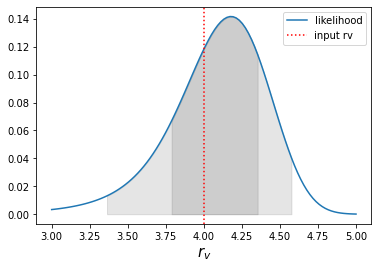

In [61]:
def nSigmaPercentile(x, likelihood, n=1):
    c = np.cumsum(likelihood)
    c /= c[-1]
    if (n==1):
        x0 = x[np.where(c<0.16)][-1]
        x1 = x[np.where(c<0.84)][-1]
    elif (n==2):
        x0 = x[np.where(c<0.025)][-1]
        x1 = x[np.where(c<0.975)][-1]
    elif (n==3):
        x0 = x[np.where(c<0.005)][-1]
        x1 = x[np.where(c<0.995)][-1]
    else:
        print ("invalid confidence band")
        return None
    return x0, x1

def loglike(x, y, p, invcov):
    dx = prof(x, *p) - y
    return -0.5* np.dot(dx.T, np.dot(invcov, dx))

ll = []
px = np.linspace(0.75,1.25, 100)
for x in px:
    p1 = p*np.array([1,1,x,1,1])
    ll.append(loglike(rmesh[mask_mesh].flatten(), np.mean(delta, axis=0).flatten(), p1, invcov))
    
ll = np.array(ll)
x = px*p[2]
plt.plot(x, np.exp(ll), "C0-", label="likelihood")
plt.axvline(x=p[2], ls=":", color="r", label="input rv")

CLlow, CLhigh = nSigmaPercentile(x, np.exp(ll), n=2)
plt.fill_between(x, np.exp(ll), where=(x>CLlow)&(x<CLhigh), color="k", alpha=0.1)
print("2 Sigma=%.2f, %.2f"%(CLlow, CLhigh))
CLlow, CLhigh = nSigmaPercentile(x, np.exp(ll), n=1)
plt.fill_between(x, np.exp(ll), where=(x>CLlow)&(x<CLhigh), color="k", alpha=0.1)
print("1 Sigma=%.2f, %.2f"%(CLlow, CLhigh))

plt.legend()
plt.xlabel(r"$r_v$", fontsize=15)
plt.show()

Again, plot the real profiles,

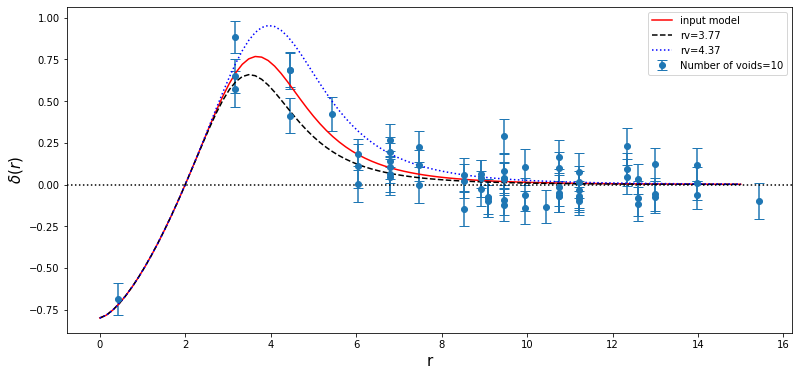

In [62]:
plt.figure(figsize=(13,6))
label="Number of voids=%i"%Nstack
plt.errorbar(rmesh[mask_mesh].flatten(), np.mean(delta,axis=0), np.std(delta,axis=0)/np.sqrt(n), ls="none", marker="o", capsize=5, label=label)
plt.plot(r, prof(r, *p), "r-", label="input model")
p1 = p.copy()
p1[2] = CLlow
plt.plot(r, prof(r, *p1), "k--", label="rv=%.2f"%CLlow)
p1[2] = CLhigh
plt.plot(r, prof(r, *p1), "b:", label="rv=%.2f"%CLhigh)
plt.axhline(y=0, ls=":", color="k")
plt.xlabel("r", fontsize=15)
plt.ylabel(r"$\delta(r)$", fontsize=15)
plt.legend()
plt.show()

## N-D parameters

In [63]:
import emcee as mc
from tqdm import tqdm
import time
from multiprocessing import Pool

labels = [r"$\delta_c$", r"$r_v$", r"$r_s$", r"$\alpha$", r"$\beta$" ]

In [64]:
def log_likelihood(theta, x, y, invcov):
    model = prof(x, *theta)
    qq = loglike(x, y, theta, invcov)
    if ( qq != qq ):
        print (qq, theta)
    return qq, model

In [65]:
def log_prior(theta):
    cond = (theta[0]<-10)|(theta[0]>0)|(theta[1]<0)|(theta[2]<0)|(theta[3]<0)|(theta[4]<0) | (theta[1]>10) | (theta[2]>10) | (theta[3]>10) | (theta[4]>20)
    if cond:
        return -np.inf
    else:
        return 0.0

In [66]:
def log_probability(theta, x, y, invcov):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf, y
    lnlike, blob = log_likelihood(theta, x, y, invcov)
    r = lp+lnlike
    if ( not np.isfinite(r) ):
        r = -np.inf
    return r, blob

In [67]:
pos = p +1e-4 * np.random.randn(32, p.shape[0])
nwalkers, ndim = pos.shape
nbunch = 2
nsteps = 100000

x = rmesh[mask_mesh].flatten()
y = np.mean(delta, axis=0).flatten()


#with Pool(4) as pool:
sampler = mc.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, invcov))#, pool=pool)
sampler.run_mcmc(pos, nsteps, progress=True)



"""
for i in tqdm(range(nbunch)):
    if i == 0:
        pos = pos
    else:
        pos = sampler.chain[:,-1,:]
    s = time.time()
    sampler.run_mcmc(pos, nsteps)
    e = time.time()

    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    labels = [r"$\delta_c$", r"$r_v$", r"$r_s$", r"$\alpha$", r"$\beta$" ]

    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

        axes[-1].set_xlabel("step number");
    #print("time for 300 steps = "+str(e-s)+" sec")
    """
print()

100%|██████████| 100000/100000 [04:52<00:00, 342.12it/s]

In [68]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(213120, 5)


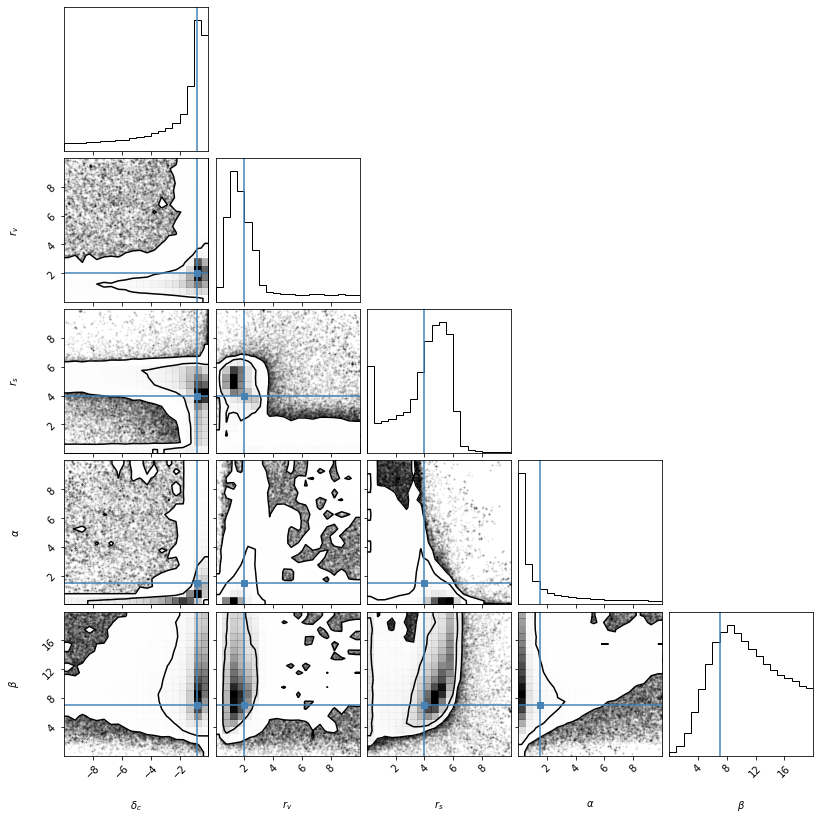

In [69]:
import corner
fig = corner.corner(
    flat_samples, labels=labels, truths=p, levels=[0.68, 0.95]
);

In [70]:
#get MLE and confidence regions
p_mcmc = np.empty((5,3))
for ip in range(5):
    p_mcmc[ip] = np.percentile(flat_samples[:,ip], [16, 50, 84])
    cl = np.diff(p_mcmc[ip])
    p_mcmc[ip,0]=p_mcmc[ip,1]
    p_mcmc[ip,1]=cl[0]
    p_mcmc[ip,2]=cl[1]
    
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(p_mcmc[ip,0], p_mcmc[ip,1], p_mcmc[ip,2], labels[ip])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

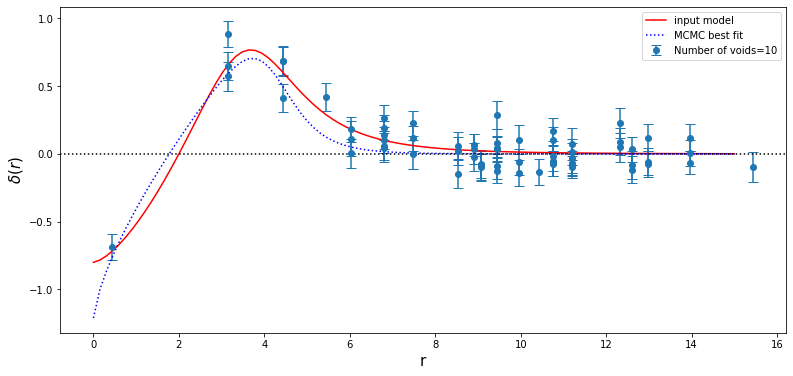

In [71]:
plt.figure(figsize=(13,6))
label="Number of voids=%i"%Nstack
plt.errorbar(rmesh.flatten(), np.mean(delta,axis=0), np.std(delta,axis=0)/np.sqrt(n), ls="none", marker="o", capsize=5, label=label)
plt.plot(r, prof(r, *p), "r-", label="input model")
p1 = p_mcmc[:,0]
plt.plot(r, prof(r, *p1), "b:", label="MCMC best fit")
plt.axhline(y=0, ls=":", color="k")
plt.xlabel("r", fontsize=15)
plt.ylabel(r"$\delta(r)$", fontsize=15)
plt.legend()
plt.show()

# 2D parameters 
to see why the alpha is negatively biased.  
From 5D parameter space, alpha seems to strongly degenerate with r_s.  Let's see if this is true in 2D fit.

In [178]:
Nx = 100
Ny = 100
ll = np.empty((Nx, Ny))

px = np.linspace(0.2,1.9, 100)
for ix, x in enumerate(px):
    for iy, y in enumerate(px):
        p1 = p*np.array([1,1,x,y,1])
        ll[ix,iy] = loglike(rmesh.flatten(), np.mean(delta, axis=0).flatten(), p1, invcov)
        
ll /= ll.max()

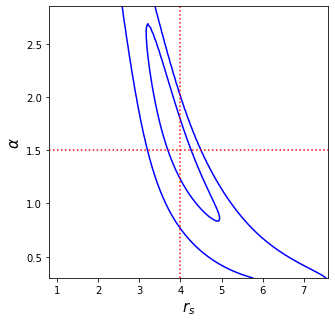

In [181]:
x = px*p[2]
y = px*p[3]
xx, yy = np.meshgrid(x,y,indexing="ij")
plt.figure(figsize=(5,5))
plt.contour(xx, yy, np.exp(-np.abs(ll)), levels=[0.04978, 0.22313], colors="b")
plt.axvline(x=p[2], color="r", ls=":")
plt.axhline(y=p[3], color="r", ls=":")
plt.xlabel(r"$r_s$", fontsize=15)
plt.ylabel(r"$\alpha$", fontsize=15)
plt.show()

# Theoretical expectations

In [192]:
import matplotlib.cm as cm

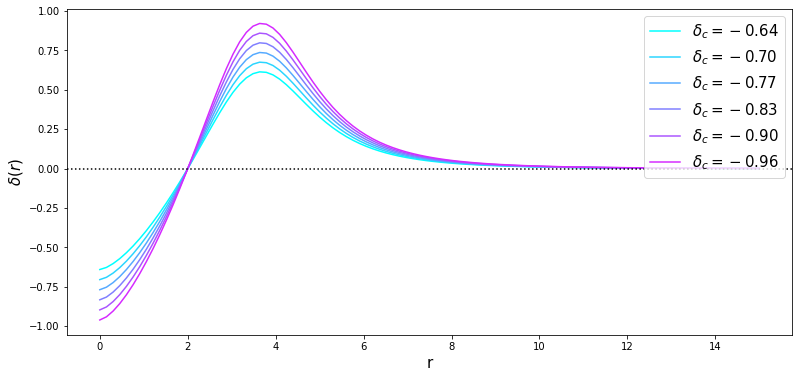

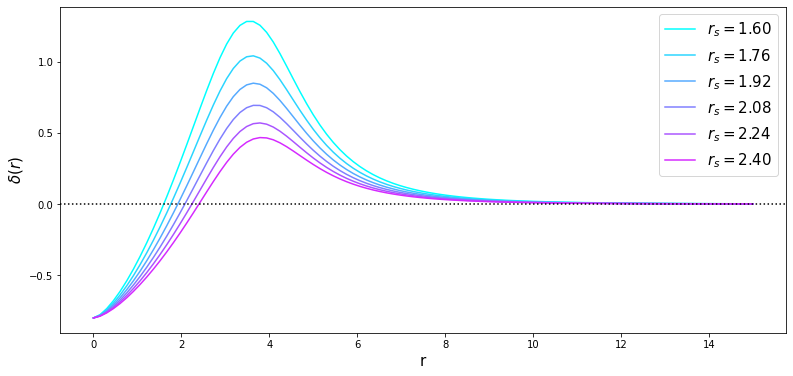

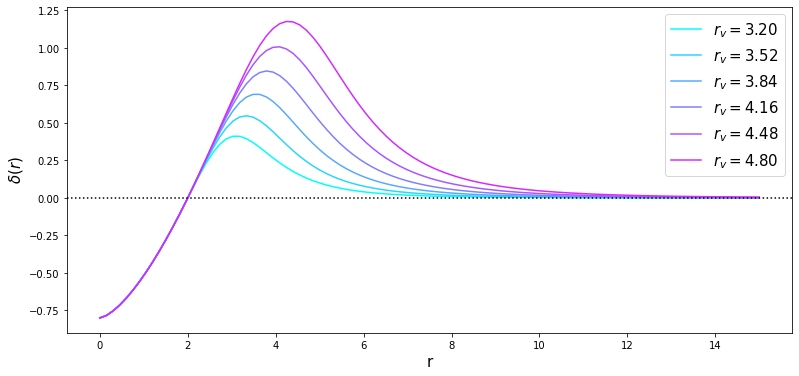

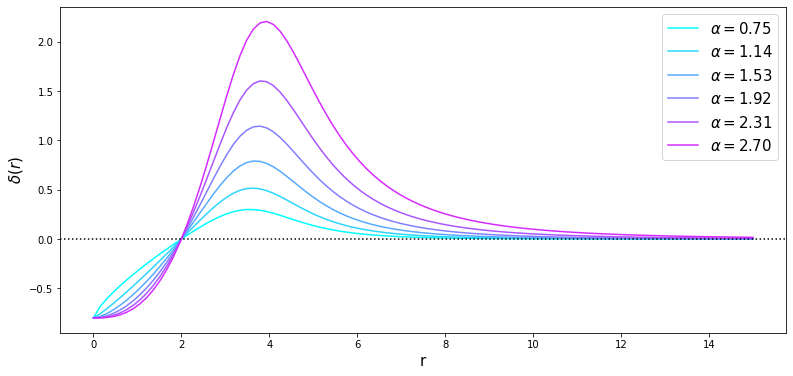

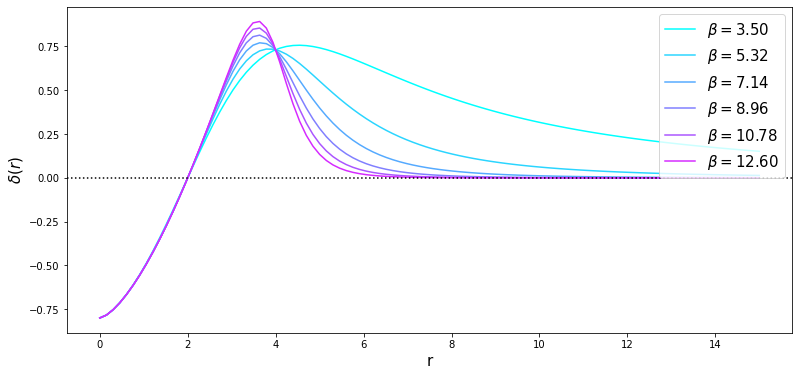

In [211]:
def plot_variant(values, ind, labels):
    N = len(values)
    plt.figure(figsize=(13,6))
    
    for i, x in enumerate(values):
        p1 = p.copy()
        p1[ind] = p[ind]*x
        plt.plot(r, prof(r, *p1), c=cm.cool(i/N), label=labels[i])
    plt.axhline(y=0, ls=":", color="k")
    plt.xlabel("r", fontsize=15)
    plt.ylabel(r"$\delta(r)$", fontsize=15)
    plt.legend(loc="upper right", fontsize=15)
    plt.show()
    
    
ind = 0
values = np.linspace(0.8, 1.2, 6)
labels_ = []
for v in values:
    labels_.append(labels[ind]+r"$=%.2f$"%(p[ind]*v))
plot_variant(values, ind, labels_)

ind = 1
values = np.linspace(0.8, 1.2, 6)
labels_ = []
for v in values:
    labels_.append(labels[ind]+r"$=%.2f$"%(p[ind]*v))
plot_variant(values, ind, labels_)

ind = 2
values = np.linspace(0.8, 1.2, 6)
labels_ = []
for v in values:
    labels_.append(labels[ind]+r"$=%.2f$"%(p[ind]*v))
plot_variant(values, ind, labels_)

ind = 3
values = np.linspace(0.5, 1.8, 6)
labels_ = []
for v in values:
    labels_.append(labels[ind]+r"$=%.2f$"%(p[ind]*v))
plot_variant(values, ind, labels_)

ind = 4
values = np.linspace(0.5, 1.8, 6)
labels_ = []
for v in values:
    labels_.append(labels[ind]+r"$=%.2f$"%(p[ind]*v))
plot_variant(values, ind, labels_)